<a href="https://colab.research.google.com/github/Ankita5051/GAN-Augmented-Gait-Analysis-for-Parkinson-s-Detection-Grading/blob/main/DA_for_pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
dataset = pd.read_pickle('preprocessed_data.pkl')
dataset.head()

,id,signal,label,UPDRS,f1,f2,f3,f4
0,GaPt03_01.txt,"[-0.18689903846153832, -0.18689903846153832, -...",1,3,0.089642,1.970602,0.601952,1.181378
1,GaPt03_01.txt,"[0.6139410187667558, 0.6588471849865947, 0.733...",1,3,-0.215587,1.520520,0.451925,1.123246
2,GaPt03_01.txt,"[-0.38434903047091407, -0.3940443213296394, -0...",1,3,-0.159324,2.197127,0.339073,1.004128
3,GaPt03_01.txt,"[0.02259887005649741, -0.0018832391713745622, ...",1,3,0.154827,1.460285,0.677901,0.977463
4,SiPt02_01.txt,"[-0.39289920915362586, -0.39289920915362586, -...",1,5,-1.414006,-1.477143,1.335888,-1.162173


In [3]:
import os
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from dotenv import load_dotenv

load_dotenv()
np.random.seed(42)

seq_len = 3000

class PDDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


X = np.array([np.array(i) for i in dataset['signal']])

y = np.array(dataset['label'])

# Train/Val/Test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)


# Create datasets & loaders
train_loader = DataLoader(PDDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(PDDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(PDDataset(X_test, y_test), batch_size=32, shuffle=False)


for batch_x, batch_y in train_loader:
    print("Batch X shape:", batch_x.shape)
    print("Batch y shape:", batch_y.shape)
    break


Batch X shape: torch.Size([32, 3000])
Batch y shape: torch.Size([32])


In [ ]:
import torch
import torch.nn as nn

class MLP_AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

In [ ]:
ae1=MLP_AE(seq_len)
ae1

MLP_AE(
  (encoder): Sequential(
    (0): Linear(in_features=3000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=3000, bias=True)
    (5): Tanh()
  )
)

In [ ]:
import torch
import torch.nn as nn

class CNN1D_AE(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_ch, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, in_ch, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon.squeeze(1)

In [ ]:
ae2=CNN1D_AE()
ae2

CNN1D_AE(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(16, 1, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): Tanh()
  )
)

In [ ]:
import torch
import torch.nn as nn

class LSTM_AE(nn.Module):
    def __init__(self, seq_len, latent_dim=32):
        super().__init__()
        self.encoder_lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.hidden2latent = nn.Linear(in_features=64, out_features=latent_dim)
        self.latent2hidden = nn.Linear(in_features=latent_dim, out_features=64)
        self.decoder_lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.output = nn.Linear(64, 1)
        self.seq_len = seq_len

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)
        _, (h, _) = self.encoder_lstm(x)
        z = self.hidden2latent(h[-1])
        h_dec = self.latent2hidden(z).unsqueeze(0)
        dec_input = torch.zeros(x.size(0), self.seq_len, 1).to(x.device)
        out, _ = self.decoder_lstm(dec_input, (h_dec, torch.zeros_like(h_dec)))
        x_recon = self.output(out)
        return x_recon.squeeze(-1)


In [ ]:
ae3=LSTM_AE(seq_len)
ae3

LSTM_AE(
  (encoder_lstm): LSTM(1, 64, batch_first=True)
  (hidden2latent): Linear(in_features=64, out_features=32, bias=True)
  (latent2hidden): Linear(in_features=32, out_features=64, bias=True)
  (decoder_lstm): LSTM(1, 64, batch_first=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

Training MLP_AE...
Epoch [5/30] | Train Loss: 0.152179 | Val Loss: 0.151489
Epoch [10/30] | Train Loss: 0.139432 | Val Loss: 0.144058
Epoch [15/30] | Train Loss: 0.134069 | Val Loss: 0.140809
Epoch [20/30] | Train Loss: 0.127497 | Val Loss: 0.137964
Epoch [25/30] | Train Loss: 0.123518 | Val Loss: 0.138277
Epoch [30/30] | Train Loss: 0.119003 | Val Loss: 0.137098

Test Reconstruction Loss: 0.129038


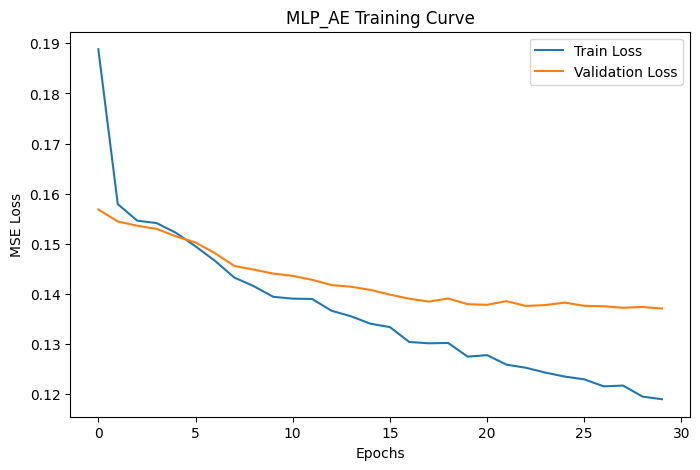

Training CNN1D_AE...
Epoch [5/30] | Train Loss: 0.004316 | Val Loss: 0.003435
Epoch [10/30] | Train Loss: 0.001195 | Val Loss: 0.001093
Epoch [15/30] | Train Loss: 0.000708 | Val Loss: 0.000666
Epoch [20/30] | Train Loss: 0.000528 | Val Loss: 0.000503
Epoch [25/30] | Train Loss: 0.000445 | Val Loss: 0.000422
Epoch [30/30] | Train Loss: 0.000375 | Val Loss: 0.000356

Test Reconstruction Loss: 0.000352


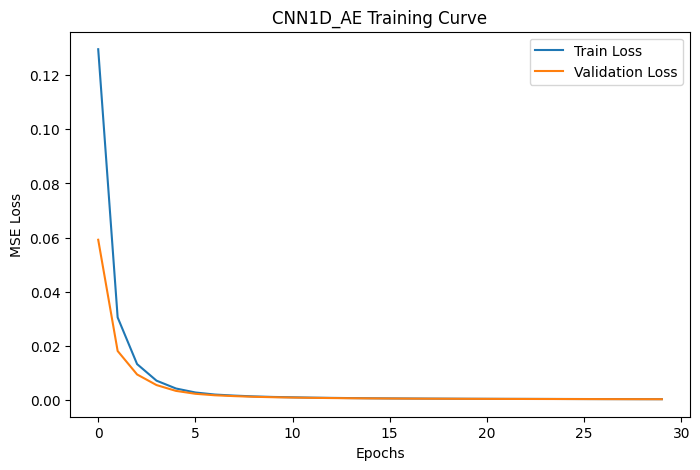

Training LSTM_AE...
Epoch [5/30] | Train Loss: 0.170793 | Val Loss: 0.170792
Epoch [10/30] | Train Loss: 0.170917 | Val Loss: 0.170747
Epoch [15/30] | Train Loss: 0.171464 | Val Loss: 0.170764
Epoch [20/30] | Train Loss: 0.171752 | Val Loss: 0.170747
Epoch [25/30] | Train Loss: 0.171760 | Val Loss: 0.170773
Epoch [30/30] | Train Loss: 0.171867 | Val Loss: 0.170755

Test Reconstruction Loss: 0.163210


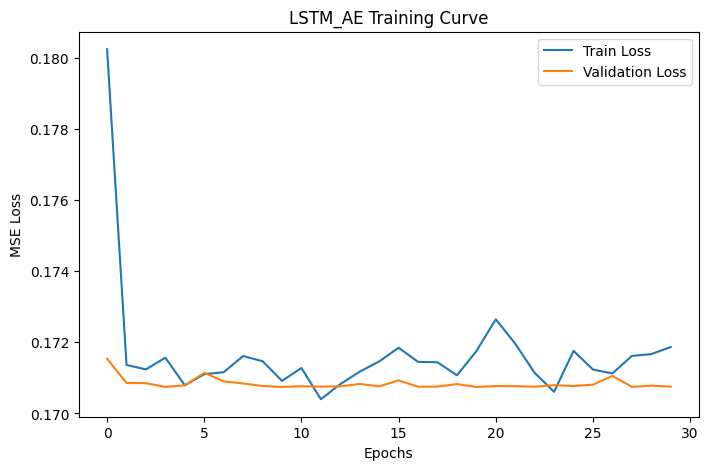

,Model Name,Epochs,Final Train Loss,Final Validation Loss,Test Reconstruction Loss
0,MLP_AE,30,0.119003,0.137098,0.129038
1,CNN1D_AE,30,0.000375,0.000356,0.000352
2,LSTM_AE,30,0.171867,0.170755,0.163210



Training results saved to training_results.md


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pandas as pd

def train_ae(model, train_loader, val_loader, test_loader, lr=0.001, epochs=80, patience=10, device='cpu'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    train_losses = []
    val_losses = []

    print(f"Training {model.__class__.__name__}...")

    for epoch in range(epochs):

        # Training phase
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device).float()
            optimizer.zero_grad()
            x_recon = model(x)
            loss = criterion(x_recon, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)


        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device).float()
                x_recon = model(x)
                loss = criterion(x_recon, x)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)


    # Test phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device).float()
            x_recon = model(x)
            loss = criterion(x_recon, x)
            test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    print(f"\nTest Reconstruction Loss: {avg_test_loss:.6f}")


    # training curve
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title(f"{model.__class__.__name__} Training Curve")
    plt.legend()
    plt.show()

    return model, train_losses, val_losses, avg_test_loss

ae1 = MLP_AE(seq_len * 1)
ae2 = CNN1D_AE(1)
ae3 = LSTM_AE(seq_len)

# Create directory for saving models if it doesn't exist
if not os.path.exists('Trained_model'):
    os.makedirs('Trained_model')

results = []

for model in [ae1, ae2, ae3]:
    model, train_losses, val_losses, test_loss = train_ae(model, train_loader, val_loader, test_loader, lr=1e-3, epochs=30)
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    model_name = model.__class__.__name__
    torch.save(model.state_dict(), f'Trained_model/{model_name}_{timestamp}.pth')

    results.append({
        'Model Name': model_name,
        'Epochs': 30,  # Since epochs is fixed at 30 in the call
        'Final Train Loss': train_losses[-1],
        'Final Validation Loss': val_losses[-1],
        'Test Reconstruction Loss': test_loss,
    })

# Display results in a table and save to a markdown file
results_df = pd.DataFrame(results)
display(results_df)

# Save results to a markdown file
with open('training_results.md', 'w') as f:
    f.write(results_df.to_markdown(index=False))

print("\nTraining results saved to training_results.md")

In [4]:
WINDOW_SIZE = 3000
NUM_VARIABLES = 1
NOISE_DIM = 128
NUM_CLASSES = 2
BATCH_SIZE = 32
EPOCHS = 10
LR_G = 0.0001
LR_D = 0.0001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# For WGAN-GP
GP_WEIGHT = 10.0
CRITIC_ITERATIONS = 5

print(f"Using device: {DEVICE}")

# Generator Model
class Generator(nn.Module):
    def __init__(self, noise_dim=NOISE_DIM, num_classes=NUM_CLASSES, seq_len=WINDOW_SIZE):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.seq_len = seq_len

        # Initial size after first dense layer
        self.init_size = 26

        # Dense layer to expand noise + condition
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + num_classes, NUM_VARIABLES * self.init_size),
            nn.ReLU(True)
        )

        # Convolutional layers with upsampling
        self.conv_blocks = nn.Sequential(
            # Block 1: 26 -> 26
            nn.Conv1d(NUM_VARIABLES, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),  # 26 -> 52

            # Block 2: 52 -> 52
            nn.Conv1d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),  # 52 -> 104

            # Block 3: 104 -> 104
            nn.Conv1d(512, 256, kernel_size=8, stride=1, padding=4),
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            # Block 4: 104 -> 104
            nn.Conv1d(256, 128, kernel_size=16, stride=1, padding=8),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            # Block 5: 104 -> 104
            nn.Conv1d(128, 64, kernel_size=32, stride=1, padding=16),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),  # 104 -> 208

            # Final layer: 208 -> 204
            nn.Conv1d(64, NUM_VARIABLES, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # One-hot encode labels
        batch_size = noise.size(0)
        labels_onehot = torch.zeros(batch_size, self.num_classes).to(noise.device)
        labels_onehot.scatter_(1, labels.long().view(-1, 1), 1)

        # Concatenate noise and labels
        gen_input = torch.cat([noise, labels_onehot], dim=1)

        # Dense layer
        x = self.fc(gen_input)
        x = x.view(batch_size, NUM_VARIABLES, self.init_size)

        # Convolutional blocks
        x = self.conv_blocks(x)

        # Interpolate to exact sequence length
        if x.size(2) != self.seq_len:
            x = nn.functional.interpolate(x, size=self.seq_len, mode='linear', align_corners=False)

        # Transpose to (batch, seq_len, channels)
        x = x.transpose(1, 2)

        return x


# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, seq_len=WINDOW_SIZE):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.seq_len = seq_len

        # Convolutional feature extractor
        self.conv_blocks = nn.Sequential(
            # Input: (batch, 1, 3000)
            nn.Conv1d(NUM_VARIABLES, 96, kernel_size=48, stride=12),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(96, 256, kernel_size=8, stride=1, padding=4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(256, 512, kernel_size=6, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(512, 512, kernel_size=4, stride=1, padding=2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(512, 1024, kernel_size=3, stride=1, padding=0),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Calculate flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, NUM_VARIABLES, seq_len)
            dummy_output = self.conv_blocks(dummy_input)
            self.flat_size = dummy_output.view(1, -1).size(1)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.flat_size + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(32, 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(8, 1)
        )

    def forward(self, x, labels):
        # x: (batch, seq_len, channels) -> (batch, channels, seq_len)
        if x.dim() == 2:
            x = x.unsqueeze(1)
        elif x.size(2) == NUM_VARIABLES:
            x = x.transpose(1, 2)

        # Extract features
        features = self.conv_blocks(x)
        features = features.view(features.size(0), -1)

        # One-hot encode labels
        batch_size = labels.size(0)
        labels_onehot = torch.zeros(batch_size, self.num_classes).to(labels.device)
        labels_onehot.scatter_(1, labels.long().view(-1, 1), 1)

        # Concatenate features and labels
        combined = torch.cat([features, labels_onehot], dim=1)

        # Final classification
        output = self.fc(combined)

        return output


Using device: cpu


In [5]:
# cGAN Training
class cGAN:
    def __init__(self, generator, discriminator, device):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=LR_G, betas=(0.5, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))

    def train_step(self, real_data, labels):
        batch_size = real_data.size(0)

        # Labels for real and fake data
        real_labels = torch.ones(batch_size, 1).to(self.device)
        fake_labels = torch.zeros(batch_size, 1).to(self.device)

        # Train Discriminator

        self.optimizer_D.zero_grad()

        # Real data
        real_output = self.discriminator(real_data, labels)
        d_loss_real = self.criterion(real_output, real_labels)

        # Fake data
        noise = torch.randn(batch_size, NOISE_DIM).to(self.device)
        fake_data = self.generator(noise, labels).detach()
        fake_output = self.discriminator(fake_data, labels)
        d_loss_fake = self.criterion(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        self.optimizer_D.step()

        # Train Generator
        self.optimizer_G.zero_grad()

        noise = torch.randn(batch_size, NOISE_DIM).to(self.device)
        fake_data = self.generator(noise, labels)
        fake_output = self.discriminator(fake_data, labels)

        g_loss = self.criterion(fake_output, real_labels)
        g_loss.backward()
        self.optimizer_G.step()

        return d_loss.item(), g_loss.item()

# cWGAN-GP
class cWGAN_GP:
    def __init__(self, generator, discriminator, device):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=LR_G, betas=(0.5, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=LR_D, betas=(0.5, 0.999))

    def gradient_penalty(self, real_data, fake_data, labels):
        batch_size = real_data.size(0)

        # Ensure real_data and fake_data have the same shape
        # Expected shape: (batch, seq_len, channels) or (batch, seq_len)
        if real_data.dim() == 2:
            real_data = real_data.unsqueeze(-1)
        if fake_data.dim() == 2:
            fake_data = fake_data.unsqueeze(-1)

        # Random weight for interpolation - shape: (batch, 1, 1)
        alpha = torch.rand(batch_size, 1, 1).to(self.device)

        # Interpolated data
        interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)

        # Discriminator output for interpolated data
        # Squeeze the last dimension if it's 1 to match discriminator input format
        d_interpolated = self.discriminator(interpolated.squeeze(-1), labels)

        # Gradients
        gradients = torch.autograd.grad(
            outputs=d_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_interpolated),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]

        # Flatten gradients
        gradients = gradients.view(batch_size, -1)

        # Calculate gradient penalty
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

        return gradient_penalty

    def train_step(self, real_data, labels):
        batch_size = real_data.size(0)

        # Train Discriminator (Critic)

        for _ in range(CRITIC_ITERATIONS):
            self.optimizer_D.zero_grad()

            # Real data
            real_output = self.discriminator(real_data, labels)
            d_loss_real = -torch.mean(real_output)

            # Fake data
            noise = torch.randn(batch_size, NOISE_DIM).to(self.device)
            fake_data = self.generator(noise, labels).detach()
            fake_output = self.discriminator(fake_data, labels)
            d_loss_fake = torch.mean(fake_output)

            # Gradient penalty
            gp = self.gradient_penalty(real_data, fake_data, labels)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake + GP_WEIGHT * gp
            d_loss.backward()
            self.optimizer_D.step()


        # Train Generator

        self.optimizer_G.zero_grad()

        noise = torch.randn(batch_size, NOISE_DIM).to(self.device)
        fake_data = self.generator(noise, labels)
        fake_output = self.discriminator(fake_data, labels)

        g_loss = -torch.mean(fake_output)
        g_loss.backward()
        self.optimizer_G.step()

        return d_loss.item(), g_loss.item()

In [ ]:
# Training Loop
def train_gan(model, train_loader, epochs, model_type='cGAN'):
    g_losses = []
    d_losses = []

    print(f"\nTraining {model_type}...")
    print(f"Total batches per epoch: {len(train_loader)}")

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for real_data, labels in pbar:
            real_data = real_data.to(DEVICE).float()
            labels = labels.to(DEVICE)

            # Train step
            d_loss, g_loss = model.train_step(real_data, labels)

            epoch_d_loss += d_loss
            epoch_g_loss += g_loss

            pbar.set_postfix({
                'D_loss': f'{d_loss:.4f}',
                'G_loss': f'{g_loss:.4f}'
            })

        # Average losses
        avg_d_loss = epoch_d_loss / len(train_loader)
        avg_g_loss = epoch_g_loss / len(train_loader)

        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)

        print(f"Epoch [{epoch+1}/{epochs}] | D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}")

        # Save samples every 10 epochs
        if (epoch + 1) % 10 == 0:
            visualize_samples(model.generator, epoch + 1, model_type)

    # Plot training losses
    plot_losses(g_losses, d_losses, model_type)

    return model

# Visualization Functions
def visualize_samples(generator, epoch, model_type, num_samples=4):
    """Generate and visualize samples"""
    generator.eval()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    with torch.no_grad():
        for i, label in enumerate([0, 0, 1, 1]):
            noise = torch.randn(1, NOISE_DIM).to(DEVICE)
            label_tensor = torch.tensor([label]).to(DEVICE)

            generated = generator(noise, label_tensor)
            generated = generated.cpu().numpy()[0, :, 0]

            axes[i].plot(generated)
            axes[i].set_title(f'Class {label} ({"No Disease" if label == 0 else "Disease"})')
            axes[i].set_xlabel('Time Steps')
            axes[i].set_ylabel('Amplitude')
            axes[i].grid(True, alpha=0.3)

    plt.suptitle(f'{model_type} - Generated Samples at Epoch {epoch}')
    plt.tight_layout()
    plt.savefig(f'{model_type}_samples_epoch_{epoch}.png', dpi=150, bbox_inches='tight')
    plt.close()

    generator.train()

def plot_losses(g_losses, d_losses, model_type):
    """Plot training losses"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_type} - Generator Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(d_losses, label='Discriminator Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_type} - Discriminator Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_type}_training_losses.png', dpi=150, bbox_inches='tight')
    plt.show()


In [ ]:
cgan=cGAN(Generator(NOISE_DIM,NUM_CLASSES,WINDOW_SIZE),Discriminator(NUM_CLASSES,WINDOW_SIZE),DEVICE)
print("cGAN Generator Architecture:")
print(cgan.generator)

print("\ncGAN Discriminator Architecture:")
print(cgan.discriminator)

cGAN Generator Architecture:
Generator(
  (fc): Sequential(
    (0): Linear(in_features=130, out_features=26, bias=True)
    (1): ReLU(inplace=True)
  )
  (conv_blocks): Sequential(
    (0): Conv1d(1, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=2.0, mode='nearest')
    (4): Conv1d(1024, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Upsample(scale_factor=2.0, mode='nearest')
    (8): Conv1d(512, 256, kernel_size=(8,), stride=(1,), padding=(4,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv1d(256, 128, kernel_size=(16,), stride=(1,), padding=(8,))
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_r

Training cGAN

Training cGAN...
Total batches per epoch: 20


Epoch 1/20: 100%|██████████| 20/20 [05:18<00:00, 15.91s/it, D_loss=0.7017, G_loss=0.7370]


Epoch [1/20] | D_loss: 0.6895 | G_loss: 0.7492


Epoch 2/20: 100%|██████████| 20/20 [05:20<00:00, 16.04s/it, D_loss=0.6917, G_loss=0.7467]


Epoch [2/20] | D_loss: 0.6859 | G_loss: 0.7313


Epoch 3/20: 100%|██████████| 20/20 [05:09<00:00, 15.50s/it, D_loss=0.5934, G_loss=0.7496]


Epoch [3/20] | D_loss: 0.6639 | G_loss: 0.8368


Epoch 4/20: 100%|██████████| 20/20 [05:18<00:00, 15.94s/it, D_loss=0.6098, G_loss=0.8937]


Epoch [4/20] | D_loss: 0.6387 | G_loss: 0.9005


Epoch 5/20: 100%|██████████| 20/20 [05:07<00:00, 15.37s/it, D_loss=0.5322, G_loss=1.1901]


Epoch [5/20] | D_loss: 0.5657 | G_loss: 1.1598


Epoch 6/20: 100%|██████████| 20/20 [05:10<00:00, 15.55s/it, D_loss=0.2147, G_loss=1.5889]


Epoch [6/20] | D_loss: 0.3811 | G_loss: 1.6040


Epoch 7/20: 100%|██████████| 20/20 [05:20<00:00, 16.03s/it, D_loss=0.1483, G_loss=2.2826]


Epoch [7/20] | D_loss: 0.4356 | G_loss: 2.1200


Epoch 8/20: 100%|██████████| 20/20 [05:15<00:00, 15.78s/it, D_loss=0.1447, G_loss=2.0420]


Epoch [8/20] | D_loss: 0.2999 | G_loss: 2.3431


Epoch 9/20: 100%|██████████| 20/20 [05:07<00:00, 15.37s/it, D_loss=0.1102, G_loss=4.9346]


Epoch [9/20] | D_loss: 0.1482 | G_loss: 3.2504


Epoch 10/20: 100%|██████████| 20/20 [05:12<00:00, 15.62s/it, D_loss=0.0520, G_loss=4.4585]


Epoch [10/20] | D_loss: 0.1707 | G_loss: 3.3635


Epoch 11/20: 100%|██████████| 20/20 [05:04<00:00, 15.21s/it, D_loss=0.0176, G_loss=5.4082]


Epoch [11/20] | D_loss: 0.0613 | G_loss: 4.6724


Epoch 12/20: 100%|██████████| 20/20 [05:00<00:00, 15.04s/it, D_loss=0.0367, G_loss=3.6887]


Epoch [12/20] | D_loss: 0.0444 | G_loss: 5.7293


Epoch 13/20: 100%|██████████| 20/20 [05:02<00:00, 15.10s/it, D_loss=0.0116, G_loss=3.1615]


Epoch [13/20] | D_loss: 0.0289 | G_loss: 6.4409


Epoch 14/20: 100%|██████████| 20/20 [05:04<00:00, 15.24s/it, D_loss=0.0313, G_loss=8.2071]


Epoch [14/20] | D_loss: 0.0391 | G_loss: 7.0610


Epoch 15/20: 100%|██████████| 20/20 [05:02<00:00, 15.15s/it, D_loss=0.0036, G_loss=8.1554]


Epoch [15/20] | D_loss: 0.0241 | G_loss: 7.2920


Epoch 16/20: 100%|██████████| 20/20 [05:01<00:00, 15.07s/it, D_loss=0.0224, G_loss=9.6401]


Epoch [16/20] | D_loss: 0.0279 | G_loss: 7.8651


Epoch 17/20: 100%|██████████| 20/20 [05:00<00:00, 15.05s/it, D_loss=0.0024, G_loss=8.7207]


Epoch [17/20] | D_loss: 0.0214 | G_loss: 8.2876


Epoch 18/20: 100%|██████████| 20/20 [05:44<00:00, 17.20s/it, D_loss=0.4395, G_loss=0.8442]


Epoch [18/20] | D_loss: 1.5136 | G_loss: 7.1473


Epoch 19/20: 100%|██████████| 20/20 [04:59<00:00, 14.98s/it, D_loss=0.6939, G_loss=0.9989]


Epoch [19/20] | D_loss: 0.4970 | G_loss: 1.2328


Epoch 20/20: 100%|██████████| 20/20 [05:01<00:00, 15.05s/it, D_loss=0.6708, G_loss=0.9080]


Epoch [20/20] | D_loss: 0.6863 | G_loss: 0.9216


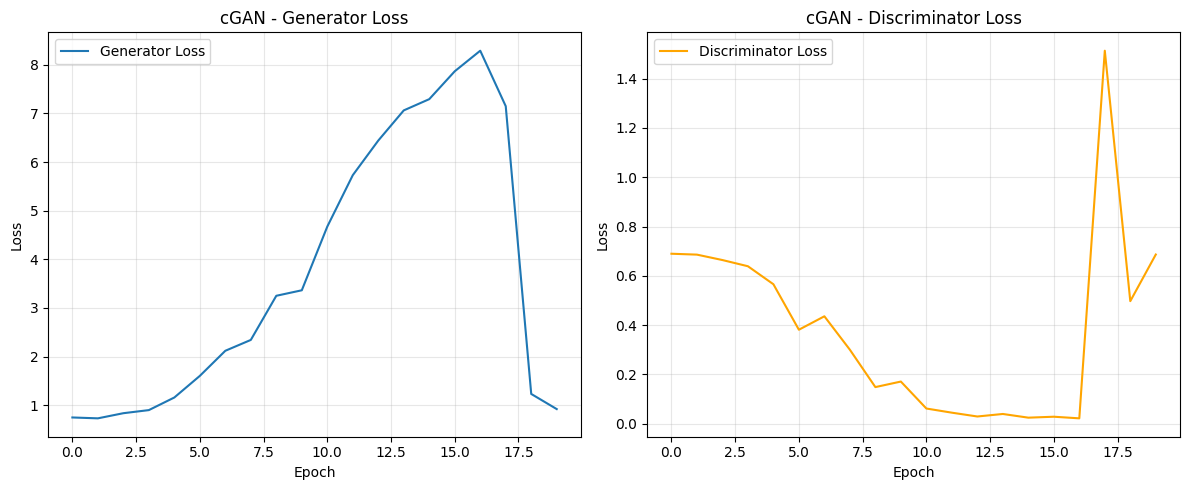

In [ ]:
print("="*60)
print("Training cGAN")
print("="*60)

# Initialize models
generator_cgan = Generator()
discriminator_cgan = Discriminator()

# Create cGAN model
cgan_model = cGAN(generator_cgan, discriminator_cgan, DEVICE)

# Train cGAN
cgan_model = train_gan(cgan_model, train_loader, EPOCHS, model_type='cGAN')

# Save cGAN model
torch.save(cgan_model.generator.state_dict(), 'cgan_generator.pth')
torch.save(cgan_model.discriminator.state_dict(), 'cgan_discriminator.pth')



Generate Synthetic Data

Enter class (0 for No Disease, 1 for Disease: 1
Enter number of samples to generate: 20

Generated 20 samples for class 1
Shape of generated data: (20, 3000)
Generated data saved to 'generated_class_1_data.csv'


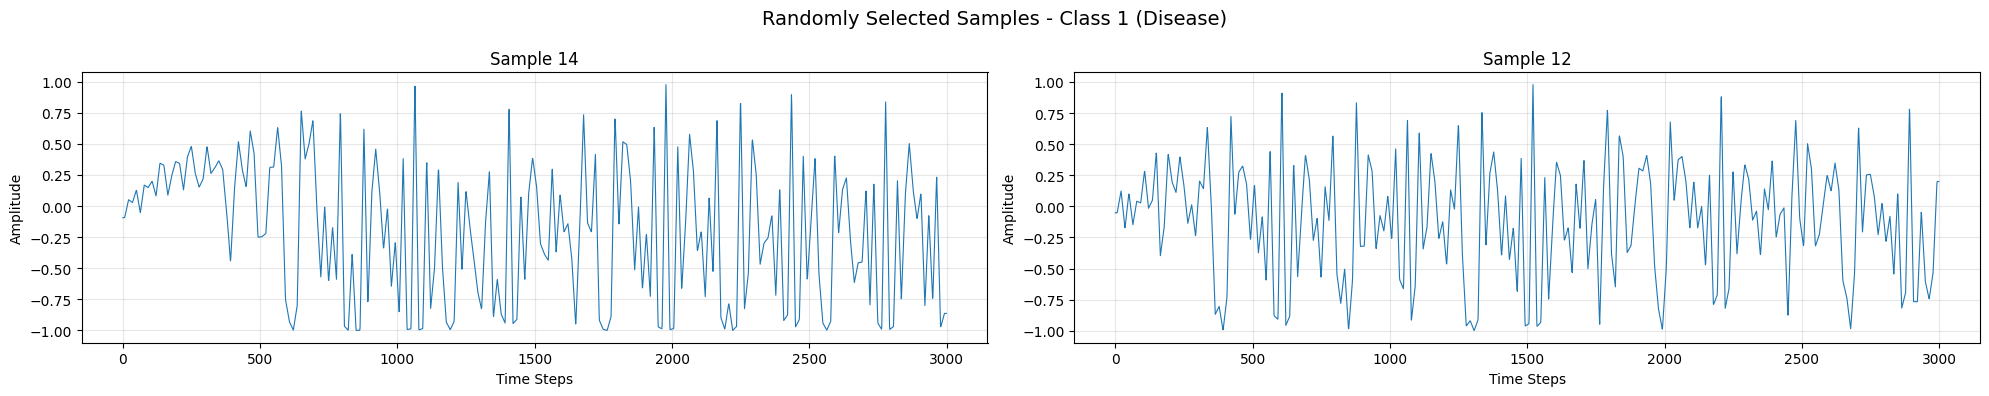

In [10]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import random

def generate_samples(generator, class_label, num_samples):
    """Generate samples without visualization."""
    generator.eval()
    generated_samples = []

    with torch.no_grad():
        for _ in range(num_samples):
            noise = torch.randn(1, NOISE_DIM).to(DEVICE)
            label_tensor = torch.tensor([class_label]).to(DEVICE)
            generated = generator(noise, label_tensor)
            generated_samples.append(generated.cpu().numpy()[0, :, 0])

    generator.train()
    return np.array(generated_samples)


def visualize_random_samples(samples, class_label, num_to_show=2):
    """Randomly visualize a few generated samples."""
    if len(samples) == 0:
        print("No samples available for visualization.")
        return

    class_name = "No Disease" if class_label == 0 else "Disease"

    # Select random samples for visualization
    random_indices = random.sample(range(len(samples)), min(num_to_show, len(samples)))
    selected_samples = samples[random_indices]

    fig, axes = plt.subplots(1, len(selected_samples), figsize=(20, 4))
    if len(selected_samples) == 1:
        axes = [axes]

    for i, sample in enumerate(selected_samples):
        axes[i].plot(sample, linewidth=0.8)
        axes[i].set_title(f'Sample {random_indices[i] + 1}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)

    plt.suptitle(f'Randomly Selected Samples - Class {class_label} ({class_name})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'generated_class_{class_label}_random_samples.png', dpi=150, bbox_inches='tight')
    plt.show()



print("\n" + "="*60)
print("Generate Synthetic Data")
print("="*60)

# Load the trained cGAN generator
generator_cgan = Generator().to(DEVICE)
generator_cgan.load_state_dict(torch.load('cgan_generator.pth'))
generator_to_use = generator_cgan


try:
    class_input = input("\nEnter class (0 for No Disease, 1 for Disease: ")


    class_label = int(class_input)
    if class_label not in [0, 1]:
        print("Invalid class!")

    num_samples = int(input("Enter number of samples to generate: "))
    if num_samples <= 0:
        print("Number of samples must be positive!")

    # Generate samples
    generated_data = generate_samples(generator_to_use, class_label, num_samples)
    print(f"\nGenerated {num_samples} samples for class {class_label}")
    print(f"Shape of generated data: {generated_data.shape}")

    # Save all generated samples to CSV
    generated_df = pd.DataFrame({
        'signal': list(generated_data),
        'label': class_label,
        'severity': 5
    })
    csv_filename = f'generated_class_{class_label}_data.csv'
    generated_df.to_csv(csv_filename, index=False)
    print(f"Generated data saved to '{csv_filename}'")

    # Visualize only 2 random samples
    visualize_random_samples(generated_data, class_label, num_to_show=2)

except ValueError:
    print("Invalid input! Please enter valid numbers.")



Training cWGAN-GP

Training cWGAN-GP...
Total batches per epoch: 20


Epoch 1/10: 100%|██████████| 20/20 [37:45<00:00, 113.28s/it, D_loss=-13.0738, G_loss=-0.3198]


Epoch [1/10] | D_loss: -7.4079 | G_loss: -4.8414


Epoch 2/10: 100%|██████████| 20/20 [37:04<00:00, 111.24s/it, D_loss=-7.4375, G_loss=-6.7878]


Epoch [2/10] | D_loss: -2.0234 | G_loss: -10.8745


Epoch 3/10: 100%|██████████| 20/20 [37:08<00:00, 111.40s/it, D_loss=-9.1796, G_loss=-20.9970]


Epoch [3/10] | D_loss: -4.4890 | G_loss: -9.5766


Epoch 4/10: 100%|██████████| 20/20 [36:52<00:00, 110.62s/it, D_loss=-7.0950, G_loss=-11.3564]


Epoch [4/10] | D_loss: -2.2443 | G_loss: -7.8660


Epoch 5/10: 100%|██████████| 20/20 [37:07<00:00, 111.37s/it, D_loss=-13.1670, G_loss=-38.0582]


Epoch [5/10] | D_loss: -3.7851 | G_loss: -12.4276


Epoch 6/10: 100%|██████████| 20/20 [37:21<00:00, 112.06s/it, D_loss=-6.6537, G_loss=2.7946]


Epoch [6/10] | D_loss: -5.3375 | G_loss: -13.8616


Epoch 7/10: 100%|██████████| 20/20 [37:25<00:00, 112.28s/it, D_loss=-3.8506, G_loss=-25.6612]


Epoch [7/10] | D_loss: -6.3129 | G_loss: -18.4874


Epoch 8/10: 100%|██████████| 20/20 [37:12<00:00, 111.64s/it, D_loss=-10.1094, G_loss=0.8395]


Epoch [8/10] | D_loss: -7.2532 | G_loss: -16.6074


Epoch 9/10: 100%|██████████| 20/20 [37:25<00:00, 112.27s/it, D_loss=12.3835, G_loss=-4.6720]


Epoch [9/10] | D_loss: -5.3531 | G_loss: -8.1515


Epoch 10/10: 100%|██████████| 20/20 [36:57<00:00, 110.87s/it, D_loss=-4.3799, G_loss=-4.8153]


Epoch [10/10] | D_loss: -8.9422 | G_loss: -10.9793


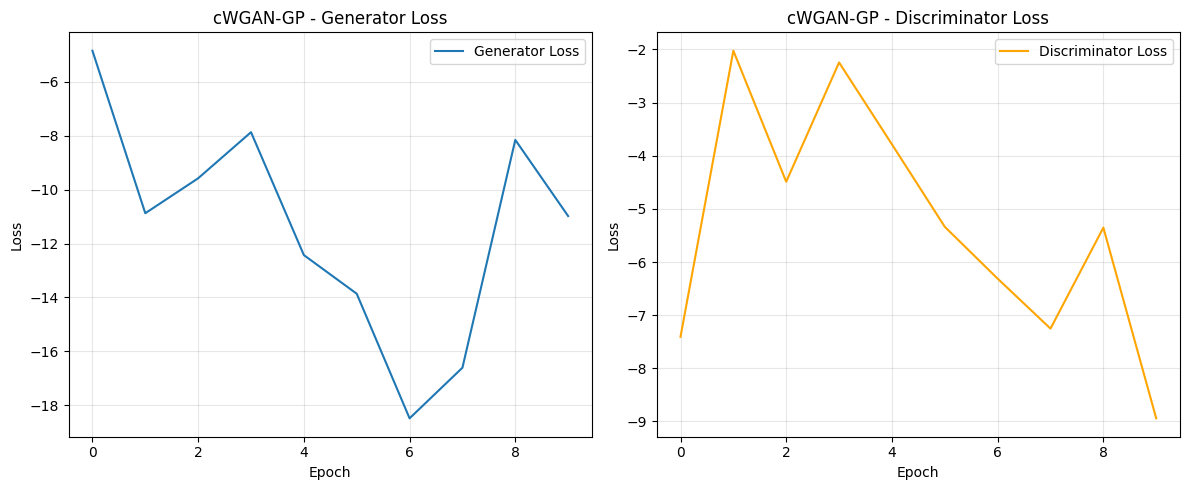


Training completed!


In [ ]:
# Training cWGAN
print("\n" + "="*60)
print("Training cWGAN-GP")
print("="*60)

# Initialize new models for WGAN
generator_wgan = Generator()
discriminator_wgan = Discriminator()

# Create cWGAN model
cwgan_model = cWGAN_GP(generator_wgan, discriminator_wgan, DEVICE)

# Train cWGAN
cwgan_model = train_gan(cwgan_model, train_loader, EPOCHS, model_type='cWGAN-GP')

# Save cWGAN model
torch.save(cwgan_model.generator.state_dict(), 'cwgan_generator.pth')
torch.save(cwgan_model.discriminator.state_dict(), 'cwgan_discriminator.pth')

print("\nTraining completed!")


Generate Synthetic Data

Enter class (0 for No Disease, 1 for Disease: 0
Enter number of samples to generate: 5

Generated 5 samples for class 0
Shape of generated data: (5, 3000)
Generated data saved to 'generated_class_0_data.csv'


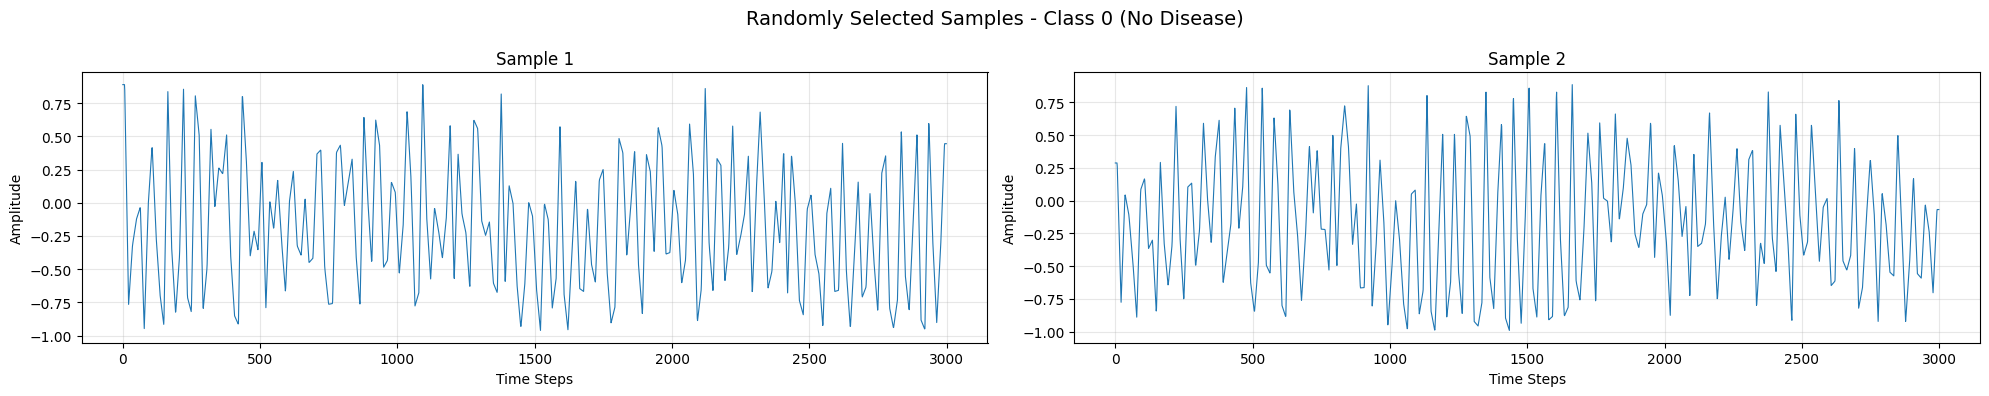

In [12]:
def visualize_random_samples(samples, class_label, num_to_show=2):
    """Randomly visualize a few generated samples."""
    if len(samples) == 0:
        print("No samples available for visualization.")
        return

    class_name = "No Disease" if class_label == 0 else "Disease"

    # Select random samples for visualization
    random_indices = random.sample(range(len(samples)), min(num_to_show, len(samples)))
    selected_samples = samples[random_indices]

    fig, axes = plt.subplots(1, len(selected_samples), figsize=(20, 4))
    if len(selected_samples) == 1:
        axes = [axes]

    for i, sample in enumerate(selected_samples):
        axes[i].plot(sample, linewidth=0.8)
        axes[i].set_title(f'Sample {random_indices[i] + 1}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)

    plt.suptitle(f'Randomly Selected Samples - Class {class_label} ({class_name})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'generated_class_{class_label}_random_samples.png', dpi=150, bbox_inches='tight')
    plt.show()



print("\n" + "="*60)
print("Generate Synthetic Data")
print("="*60)

# Load the trained cGAN generator
generator_cgan = Generator().to(DEVICE)
generator_cgan.load_state_dict(torch.load('cwgan_generator.pth'))
generator_to_use = generator_cgan


try:
    class_input = input("\nEnter class (0 for No Disease, 1 for Disease: ")


    class_label = int(class_input)
    if class_label not in [0, 1]:
        print("Invalid class!")

    num_samples = int(input("Enter number of samples to generate: "))
    if num_samples <= 0:
        print("Number of samples must be positive!")

    # Generate samples
    generated_data = generate_samples(generator_to_use, class_label, num_samples)
    print(f"\nGenerated {num_samples} samples for class {class_label}")
    print(f"Shape of generated data: {generated_data.shape}")

    # Save all generated samples to CSV
    generated_df = pd.DataFrame({
        'signal': list(generated_data),
        'label': class_label,
        'severity': 5
    })
    csv_filename = f'generated_class_{class_label}_data.csv'
    generated_df.to_csv(csv_filename, index=False)
    print(f"Generated data saved to '{csv_filename}'")

    # Visualize only 2 random samples
    visualize_random_samples(generated_data, class_label, num_to_show=2)

except ValueError:
    print("Invalid input! Please enter valid numbers.")
